# Progetto Data Mining: Intrusion Detection System 

**Studenti:** Miriello Raffaele (227564) e Francesco Palumbo (235805)

Il seguente progetto si pone come scopo l'analisi di dati provenienti da Intrusion Detection Systems (IDSs), i quali sono i più importanti strumenti di difesa per gli attacchi sempre più sofisticati che attaccano le reti.

Il dataset **CICIDS2017**, utilizzato in questo notebook, contiene attacchi benigni e comuni più recenti, che assomigliano ai dati reali (PCAP). Include inoltre il risultato dell'analisi del traffico di rete utilizzando **CICFlowMeter** i cui flussi sono etichettati con timestamp, IP sorgente e destinazione, Porta sorgente e destinazione, protocolli e attacco.

Si è pensato quindi proprio di andare a fare classificazione sull'attributo **Label**, del quale verranno nel seguito mostrati i possibili valori e le sue caratteristiche.

**Link al dataset**: https://www.unb.ca/cic/datasets/ids-2017.html

Importazione delle librerie utili alle analisi:

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import pickle
from sklearn.pipeline import Pipeline

# Loading DataSet

I dati sono suddivisi in più dataset ognuno per giorno in cui sono stati catturati i dati. Vengono quindi uniti in un unico dataframe per poi poter eseguire comodamente tutte le operazioni successive.

In [7]:
df = pd.read_csv("Dm-Project/dataset/dataset/Wednesday-WorkingHours.csv")
df = pd.concat([df, pd.read_csv("Dm-Project/dataset/dataset/Thursday-WorkingHours.csv")])
df = pd.concat([df, pd.read_csv("Dm-Project/dataset/dataset/Tuesday-WorkingHours.csv")])
df = pd.concat([df, pd.read_csv("Dm-Project/dataset/dataset/Monday-WorkingHours.csv")])
df = pd.concat([df, pd.read_csv("Dm-Project/dataset/dataset/Friday-WorkingHours.csv")])

Si mostra la struttura del dataset attraverso il comando **info()**

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2100814 entries, 0 to 547914
Data columns (total 84 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   Flow ID                     object 
 1   Src IP                      object 
 2   Src Port                    int64  
 3   Dst IP                      object 
 4   Dst Port                    int64  
 5   Protocol                    int64  
 6   Timestamp                   object 
 7   Flow Duration               int64  
 8   Total Fwd Packet            int64  
 9   Total Bwd packets           int64  
 10  Total Length of Fwd Packet  float64
 11  Total Length of Bwd Packet  float64
 12  Fwd Packet Length Max       float64
 13  Fwd Packet Length Min       float64
 14  Fwd Packet Length Mean      float64
 15  Fwd Packet Length Std       float64
 16  Bwd Packet Length Max       float64
 17  Bwd Packet Length Min       float64
 18  Bwd Packet Length Mean      float64
 19  Bwd Packet Length Std 

# Cleaning DataSet

Come visto tramite l'output del comando precedente abbiamo tante colonne ed anche una grossa quantità di entry. 
Procediamo ad un analisi delle colonne per eliminare eventuali valori nulli ed effettuare ulteriore pulizia su colonne non importanti allo scopo dell'analisi.

In [9]:
pd.DataFrame(df.isnull().sum()).sort_values(ascending=0,by=[0])

,0
Flow Bytes/s,602
Flow IAT Mean,252
Flow IAT Std,252
Flow IAT Min,252
Flow IAT Max,252
...,...
Fwd IAT Min,0
Fwd IAT Max,0
Fwd IAT Std,0
Fwd IAT Mean,0


Notiamo che in particolare la colonna *Flow Bytes/s* presenta valori nulli, i quali sono comunque in bassa percentuale rispetto al totale per cui eliminiamo direttamente le righe attraverso il metodo *drop*.

In [10]:
rows = df.loc[df['Flow Bytes/s'].isnull()]
df.drop(labels=rows.index,axis=0,inplace=True)
df.shape

(2098292, 84)

In [11]:
pd.DataFrame(df.isnull().sum()).sort_values(ascending=0,by=[0])

,0
Flow IAT Mean,174
Flow IAT Min,174
Flow IAT Max,174
Flow IAT Std,174
Packet Length Variance,0
...,...
Fwd IAT Max,0
Fwd IAT Std,0
Fwd IAT Mean,0
Fwd IAT Total,0


In [12]:
df[df['Flow IAT Mean'].isnull()]['Flow Duration'].value_counts()

0    174
Name: Flow Duration, dtype: int64

Notiamo dunque che quando l'Inter Arrival Time (IAT, il tempo che intercorre tra l'arrivo di un pacchetto e il prossimo) è nullo è poiché il flow stesso è durato 0s per cui non stiamo parlando di dati anomali ma di proprietà intrinseche dei dati.

Eliminiamo le righe che hanno valori all'infinito

In [13]:
rows = df.loc[np.isinf(df.select_dtypes(exclude=object)).any(1)]
df.drop(labels=rows.index,axis=0,inplace=True)
df.shape

C:\Users\mirie\AppData\Local\Temp\ipykernel_12360\854095094.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  rows = df.loc[np.isinf(df.select_dtypes(exclude=object)).any(1)]


(2097341, 84)

Il modello non deve imparare pattern in base agli IP e dunque eliminiamo le relative colonne (Flow ID è un'unione di altre colonne già presenti).

In [14]:
df.drop(["Flow ID","Src IP","Dst IP","Timestamp"],axis=1,inplace=True)

# Classificatore Binario (Benigno/Maligno)

Dopo aver effettuato la prima fase di preprocessing dei dati ci concentriamo ora sulla colonna **Label** la quale rappresenta l'etichetta della classe a cui il record appartiene.

In [15]:
df["Label"].value_counts()

BENIGN                                  1654877
PortScan                                 158960
DoS Hulk                                 158196
DDoS                                      95026
DoS GoldenEye                              7561
DoS slowloris                              3991
FTP-Patator                                3962
DoS Slowhttptest - Attempted               3363
SSH-Patator                                2977
DoS Slowhttptest                           1737
DoS slowloris - Attempted                  1698
Bot - Attempted                            1466
Web Attack - Brute Force - Attempted       1214
Bot                                         738
Web Attack - XSS - Attempted                650
DoS Hulk - Attempted                        577
Web Attack - Brute Force                    151
DoS GoldenEye - Attempted                    80
Infiltration                                 32
Web Attack - XSS                             27
Infiltration - Attempted                

Si nota che il numero di classi è molto grande ed è caratterizzato da alcune di esse con un numero davvero molto basso di record che vi ci appartengono, questo come sappiamo non consente di effettuare una corretta classificazione avendo un dataset molto *umbalanced*. 
Per cui potremmo attuare diverse soluzioni per sopperire a questo problema, la prima che decidiamo di seguire è quella di limitarci ad effettuare la distinzione tra:
 - BENIGN
 - MALIGN

Nella seconda classe andremo a collassare tutte le altre classi diverse da BENIGN

In [16]:
df_maligne = df[df["Label"]!='BENIGN'].copy()
df_maligne["Label"] = "MALIGN"
df_maligne.shape

(442464, 80)

Per poter compensare il minor numero di record con etichetta **MALIGN** rispetto a quelli con etichetta **BENIGN** effettuiamo un semplice sampling senza utilizzare particolari strategie, argomento che verrà ritrattato nelle sezioni successive. 

In [17]:
df_bin = pd.concat([df_maligne, df[df["Label"]=='BENIGN'].sample(len(df_maligne))])
df_bin["Label"].value_counts()

MALIGN    442464
BENIGN    442464
Name: Label, dtype: int64

Dopo aver quindi sistemato i record procediamo a dividere l'intero dataset in *train set* e *test set* per poter procedere all'addestramento del modello di machine learning. Il tutto viene fatto attraverso la funzione *train_test_split*, che prende in input un valore *0,2%* che corrisponde alla dimensione del test set rispetto al dataset totale.

In [18]:
from sklearn.model_selection import train_test_split

y = df_bin["Label"]
X = df_bin.drop(columns= "Label")
X_train, X_test,  y_train, y_test = train_test_split(X,y, test_size=0.2)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(707942, 79) (707942,) (176986, 79) (176986,)


In [19]:
y_train.value_counts()

MALIGN    354052
BENIGN    353890
Name: Label, dtype: int64

Si è scelto di utilizzare come primo classificatore **Random Forest** per poter effettuare un primo train senza andare a fare alcun tipo di *parameter tuning* e poiché da la possibilità di consultare la *feature importance*. 

In [20]:
from sklearn.ensemble import RandomForestClassifier

#rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
#rnd_clf.fit(X_train,y_train)

filename = './Model/Binary/rnd_clf.sav'
#pickle.dump(rnd_clf, open(filename, 'wb'))


rnd_clf = pickle.load(open(filename, 'rb'))
y_pred = rnd_clf.predict(X_test)


Per la valutazione dei risultati di classificazione utilizziamo la funzione *classification_report* che è fornita da sklearn la quale costruire un report testuale che mostra le principali metriche di valutazione.

In particolare:
 - **Precision**: $$\frac{tp}{(tp + fp)}$$ dove *tp* è il numero di veri positivi e *fp* è il numero di falsi positivi. Ovvero misura la capacità di un classificatore di non etichettare un record positivo come negativo.
 
 - **Recall**: $$\frac{tp}{(tp + fn)}$$ dove *tp* è il numero di veri positivi e *fn* è il numero di falsi negativi. Ovvero misura la capacità di un classificatore di trovare tutti i record positivi.
 - **F1-score**: $$2*\frac{precision * recall}{(precision + recall)}$$ che rappresenta una metrica che combina le due precedenti con un egual contributo. 


In [21]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     88574
      MALIGN       1.00      1.00      1.00     88412

    accuracy                           1.00    176986
   macro avg       1.00      1.00      1.00    176986
weighted avg       1.00      1.00      1.00    176986



Le metriche ci danno un risultato di *1.00* su tutto, il che ci suggerisce che il problema di stabilire se un particolare flow è maligno o benigno è troppo semplice. A tale scopo proviamo a diminuire il numero di record per scoprire se esiste una correlazione tra quest'ultimo e le ottime performance.

In [22]:
df_rid = df_bin.sample(20000)
df_rid['Label'].value_counts()

BENIGN    10016
MALIGN     9984
Name: Label, dtype: int64

In [23]:
y_rid = df_rid["Label"]
X_rid = df_rid.drop(columns= "Label")
X_train, X_test,  y_train, y_test = train_test_split(X_rid,y_rid, test_size=0.2)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
rnd_clf.fit(X_train,y_train)
y_pred = rnd_clf.predict(X_test)

In [24]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

      BENIGN       0.99      1.00      1.00      1979
      MALIGN       1.00      1.00      1.00      2021

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



Anche con solo 20000 istanze il modello è molto performante. Proviamo allora ad eliminare le feature che hanno troppa importanza, per farlo sfruttiamo la caratteristica di *Random Forest* che ci consente di ottenere una lista ordinata di feature sulla base della loro *importance*

In [25]:
fi = sorted(zip(rnd_clf.feature_importances_, list(X.columns)), reverse=True)
fi

[(0.21577302936381987, 'RST Flag Count'),
 (0.12768874805172312, 'Bwd Packet Length Min'),
 (0.05004974198963932, 'Bwd Packet Length Std'),
 (0.04657124891913213, 'PSH Flag Count'),
 (0.046017665588972814, 'ACK Flag Count'),
 (0.04585370166171006, 'Packet Length Mean'),
 (0.043147831993477104, 'Bwd Packet Length Max'),
 (0.04295802295506969, 'Protocol'),
 (0.04204397187013442, 'Packet Length Std'),
 (0.03926106158671786, 'Bwd IAT Total'),
 (0.0326483561902003, 'Bwd IAT Max'),
 (0.030184561288746303, 'Total Bwd packets'),
 (0.025992040328306442, 'Fwd PSH Flags'),
 (0.01307116001001681, 'Dst Port'),
 (0.012915719096157829, 'Total Length of Fwd Packet'),
 (0.012769759206985096, 'Fwd IAT Max'),
 (0.012057500996178236, 'Fwd Header Length'),
 (0.011046787755806602, 'Fwd IAT Total'),
 (0.009141542294417356, 'Bwd Init Win Bytes'),
 (0.008536642416186287, 'SYN Flag Count'),
 (0.008309174216174078, 'Packet Length Variance'),
 (0.0074126100940806626, 'Fwd Seg Size Min'),
 (0.007354838140287609, '

In [26]:
fi[-15:-5]

[(0.00024135359452591873, 'Fwd Segment Size Avg'),
 (0.00022034714877609344, 'Packet Length Max'),
 (0.00016904641464898706, 'Bwd Bytes/Bulk Avg'),
 (0.0001654511178853625, 'Subflow Fwd Packets'),
 (0.00010846430108727501, 'Fwd Packet Length Min'),
 (5.816790707105539e-05, 'Flow Bytes/s'),
 (5.725738917908419e-05, 'Fwd Bulk Rate Avg'),
 (4.9234328974183056e-05, 'Bwd Packet/Bulk Avg'),
 (0.0, 'URG Flag Count'),
 (0.0, 'Subflow Bwd Packets')]

In [27]:
for _, col in fi[:-15]+fi[-5:]:
    X = X.drop(col, axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 884928 entries, 9594 to 396637
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Fwd Packet Length Min  884928 non-null  float64
 1   Flow Bytes/s           884928 non-null  float64
 2   Packet Length Max      884928 non-null  float64
 3   URG Flag Count         884928 non-null  int64  
 4   Fwd Segment Size Avg   884928 non-null  float64
 5   Fwd Bulk Rate Avg      884928 non-null  int64  
 6   Bwd Bytes/Bulk Avg     884928 non-null  int64  
 7   Bwd Packet/Bulk Avg    884928 non-null  int64  
 8   Subflow Fwd Packets    884928 non-null  int64  
 9   Subflow Bwd Packets    884928 non-null  int64  
dtypes: float64(4), int64(6)
memory usage: 74.3 MB


In [28]:
X_train, X_test,  y_train, y_test = train_test_split(X,y, test_size=0.2)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
rnd_clf.fit(X_train,y_train)
y_pred = rnd_clf.predict(X_test)

In [29]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

      BENIGN       0.99      0.94      0.96     88433
      MALIGN       0.94      0.99      0.97     88553

    accuracy                           0.97    176986
   macro avg       0.97      0.97      0.97    176986
weighted avg       0.97      0.97      0.97    176986



Dal momento che anche con solo 10 colonne tra le meno importanti il rendimento del modello è molto elevato si può dedurre che il problema di distinguere tra una connesione benevola e una maligna è troppo semplice.

# MultiClass Classification
Dopo aver constatato che il problema di classificazione binaria è troppo semplice e non ci da molte informazioni sul flow di rete, optiamo per una classificazione di tipo **multi class**, ovvero in cui non esistono solo due opzioni, ma bensì *n* opzioni.

In scikit learn tutti i classificatori possono effettuare questo tipo di classificazione, ma prima di procedere ci dobbiamo occupare del forte sbilanciamento delle classi all'interno del dataset che porterebbe a risultati non ottimi.


## Under/Over Sampling

In [30]:
df["Label"].value_counts()

BENIGN                                  1654877
PortScan                                 158960
DoS Hulk                                 158196
DDoS                                      95026
DoS GoldenEye                              7561
DoS slowloris                              3991
FTP-Patator                                3962
DoS Slowhttptest - Attempted               3363
SSH-Patator                                2977
DoS Slowhttptest                           1737
DoS slowloris - Attempted                  1698
Bot - Attempted                            1466
Web Attack - Brute Force - Attempted       1214
Bot                                         738
Web Attack - XSS - Attempted                650
DoS Hulk - Attempted                        577
Web Attack - Brute Force                    151
DoS GoldenEye - Attempted                    80
Infiltration                                 32
Web Attack - XSS                             27
Infiltration - Attempted                

Notiamo come visto anche nelle prime sezioni che abbiamo un grosso numero di classi nel dataset, alcune delle quali hanno pochi elementi per essere considerate nel processo di classificazione, a tal proposito decidiamo di selezionare le prime **4 classi** per numero di valori. 
 - BENIGN
 - PortScan
 - DoS Hulk
 - DDos

Procediamo ad effettuare un under sampling sulle tuple con label *Bening* e successivamente un over sampling sulle restanti label cercando di raggrupparle sotto macro categorie per effettuare una classificazione multiclass.

In [31]:
df_topC = df[(df["Label"] == "BENIGN") | (df["Label"] == "PortScan") | (df["Label"] == "DoS Hulk") | (df["Label"] == "DDoS")]

In [32]:
df_topC["Label"].value_counts()

BENIGN      1654877
PortScan     158960
DoS Hulk     158196
DDoS          95026
Name: Label, dtype: int64

Dopo aver selezionato le entry relative alle classi prescelte procediamo a suddividere il dataset in *train* e *test* set, poiché le operazioni di under e over sampling verranno effettuate esclusivamente sul *train set*.

In [33]:
y = df_topC["Label"]
X = df_topC.drop(columns= "Label")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

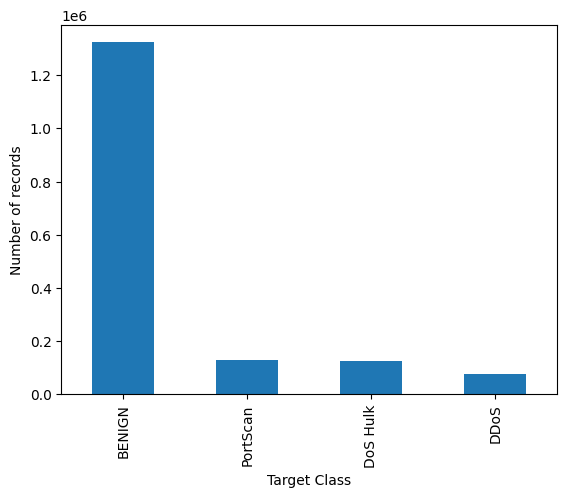

In [34]:
import matplotlib.pyplot as plt
count = y_train.value_counts()
count.plot.bar()
plt.ylabel('Number of records')
plt.xlabel('Target Class')
plt.show()

Notiamo come appunto la classe Benigna sia sbilanciata rispetto alle altre, per cui inizieremo ad effettuare un *undersampling* proprio su questa portandola a circa il numero di elementi contenuti nella seconda classe per numero *PortScan*.

E' stata utilizzata la libreria imblearn che fornisce molti metodi, tra cui quello utilizzato per questo undersampling:
- **NearMiss**: come riportato sul sito ufficiale, *NearMiss-1* seleziona i campioni positivi per i quali la distanza media dai campioni più vicini della classe negativa è minima.
<img src="Images/nearmiss.png" style="display: block;margin-left: auto;margin-right: auto;width: 30%; margin-top:2%;">


In [35]:
from imblearn.under_sampling import NearMiss

cc = NearMiss(sampling_strategy={"BENIGN":127000},version=1)

#X_under, y_under = cc.fit_resample(X_train, y_train)

filename1 = './Data/X_under_near.sav'
filename2 = './Data/y_under_near.sav'
#pickle.dump(X_under, open(filename1, 'wb'))
#pickle.dump(y_under, open(filename2, 'wb'))

X_under = pickle.load(open(filename1, 'rb'))
y_under = pickle.load(open(filename2, 'rb'))

In [36]:
y_under.value_counts()

PortScan    127122
BENIGN      127000
DoS Hulk    126542
DDoS         75993
Name: Label, dtype: int64

Lanciamo un esecuzione di prova su Random Forest per confrontare i suoi risultati prima e dopo l'oversampling di Dos e DDos

In [37]:
#rnd_clf = RandomForestClassifier(random_state=42,n_jobs=-1)
#rnd_clf.fit(X_under,y_under)

filename = './Model/MultiClass/rnd_clf.sav'
#pickle.dump(rnd_clf, open(filename, 'wb'))
rnd_clf = pickle.load(open(filename, 'rb'))

y_pred = rnd_clf.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

      BENIGN       1.00      0.44      0.61    330887
        DDoS       0.98      1.00      0.99     19033
    DoS Hulk       0.67      1.00      0.80     31654
    PortScan       0.16      1.00      0.27     31838

    accuracy                           0.55    413412
   macro avg       0.70      0.86      0.67    413412
weighted avg       0.91      0.55      0.62    413412



Per l'operazione di over sampling utilizziamo sempre un metodo offerto dalla libreria *imblearn*, in particolare:
- **SMOTE**: al contrario di un sampling randomico in cui determinati sample vengono duplicati a partire dalla classe minoritaria, questo metodo genera dei nuovi elementi a partire da quelli esistenti. 

Per farlo prima seleziona casualmente un'istanza di classe di minoranza (**a**) e trova i suoi *k* vicini di classe più vicini. L'istanza sintetica viene creata scegliendo casualmente uno dei k vicini (**b**) e connettendoli con un segmento nello spazio delle feature. Le istanze sintetiche sono generate da una combinazione convessa delle due istanze scelte *a* e *b*.

<img src="Images/smote.png" style="display: block;margin-left: auto;margin-right: auto;width: 30%; margin-top:2%;">

In [38]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(n_jobs=-1)
#X_under, y_under = sm.fit_resample(X_under, y_under)

filename1 = './Data/X_under_smote.sav'
#pickle.dump(X_under, open(filename1, 'wb'))
filename2 = './Data/y_under_smote.sav'
#pickle.dump(y_under, open(filename2, 'wb'))

X_under = pickle.load(open(filename1, 'rb'))
y_under = pickle.load(open(filename2, 'rb'))

In [39]:
y_under.value_counts()

BENIGN      127122
DDoS        127122
DoS Hulk    127122
PortScan    127122
Name: Label, dtype: int64

In seguito a queste operazioni ora il dataset è perfettamente bilanciato, per cui possiamo procedere a verificare se le performance sono migliorate.

In [40]:
#rnd_clf.fit(X_under,y_under)

filename = './Model/MultiClass/rnd_clf_1.sav'
#pickle.dump(rnd_clf, open(filename, 'wb'))
rnd_clf = pickle.load(open(filename, 'rb'))

y_pred = rnd_clf.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

      BENIGN       1.00      0.44      0.61    330887
        DDoS       0.98      1.00      0.99     19033
    DoS Hulk       0.62      1.00      0.77     31654
    PortScan       0.16      1.00      0.28     31838

    accuracy                           0.55    413412
   macro avg       0.69      0.86      0.66    413412
weighted avg       0.91      0.55      0.61    413412



Non notiamo alcuna miglioria, ma ci siamo soffermati solo su un classificatore per cui il prossimo step è provarne un altro con alcune annesse migliorie ai dati.

### Test SGD con e senza scaler
Il prossimo algoritmo di classificazione che utilizziamo è **SGD** (*Stochastic Gradient Descent*) il quale è un metodo di ottimizzazione per problemi di ottimizzazione non vincolati.
In sklearn abbiamo la classe *SGDClassifier* che implementa una routine di apprendimento SGD di primo ordine. 

L'algoritmo itera sul training set e per ogni elemento aggiorna i parametri del modello seguendo la seguente regola:
$$ w \leftarrow w - \eta \left[\alpha \frac{\partial R(w)}{\partial w}
+ \frac{\partial L(w^T x_i + b, y_i)}{\partial w}\right] $$
dove $\eta$ è il *learning rate* che può essere costante o adattivo.

In [41]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(max_iter=500,random_state=42,tol=0,n_jobs=-1)

In [42]:
#sgd.fit(X_under,y_under)

filename = './Model/MultiClass/sgd_noscaler.sav'
#pickle.dump(sgd, open(filename, 'wb'))
sgd = pickle.load(open(filename, 'rb'))

y_pred = sgd.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

      BENIGN       0.99      0.40      0.57    330887
        DDoS       0.49      0.97      0.65     19033
    DoS Hulk       0.21      0.95      0.34     31654
    PortScan       0.32      1.00      0.48     31838

    accuracy                           0.51    413412
   macro avg       0.50      0.83      0.51    413412
weighted avg       0.86      0.51      0.55    413412



I risultati ottenuti anche se peccano su **f1-score medio** sono in realtà ottimi, poiché in particolare ciò che vogliamo che sia vicino ad 1 sono la *precision* per quanto rigurda i sample benigni e la *recall* prossima ad 1 per quanto riguarda gli altri.

Nel primo caso vuol dire che tra tutti i record benigni la percentuale di coloro che sono realmente benigni è molto alta. Ovvero non stiamo facendo passare un attacco maligno per benigno.

Nel secondo caso vuol dire che tra tutti i record maligni la percentuale di coloro che erroneamente vengono classificati come benigni è molto bassa.

Nonostante ciò si può ancora migliorare di gran lunga la performance globale del classificatore, prima di procedere all'esecuzione di altri algoritmi con annesso tuning dei parametri, proviamo ad effettuare lo *scaling* delle feature nel dataset.

La **standardizzazione** di un dataset è un requisito che hanno molti algoritmi di machine learning, altrimenti le loro performance potrebbero essere influenzate negativamente. La libreria *sklearn* mette e disposizione diverse classi di utilità, in particolare vogliamo utilizzare:
- **Standard Scaler**: effettua la standardizzazione delle feature portano la media a 0 e la varianza ad 1
- **MaxMin Scaler**: effettua la standardizzazione andando a scalare le feature all'interno di un valore minimo e massimo che vengono forniti. Solitamente questi valori sono rispettivamente 0 ed 1.

Per comodità creiamo due Pipeline, un costrutto che permette di eseguire trasformazioni una dopo l'altra e come step finale l'estimatore. Così facendo potremo modificare esclusivamente il classificatore e mettere a confronto i due scaler.  

In [43]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

p_minmax = Pipeline([('scaler', MinMaxScaler()),('classifier' , sgd)]) 
p_standard = Pipeline([('scaler', StandardScaler()),('classifier' , sgd)]) 


Esecuzione con standard scaler

In [44]:
#p_standard.fit(X_under,y_under)

filename = './Model/MultiClass/sgd_p_standard.sav'
#pickle.dump(p_standard, open(filename, 'wb'))
p_standard = pickle.load(open(filename, 'rb'))

y_pred = p_standard.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

      BENIGN       1.00      0.66      0.80    330887
        DDoS       0.62      1.00      0.77     19033
    DoS Hulk       0.43      1.00      0.60     31654
    PortScan       0.36      1.00      0.53     31838

    accuracy                           0.73    413412
   macro avg       0.60      0.92      0.67    413412
weighted avg       0.89      0.73      0.76    413412



Esecuzione con minmax scaler

In [45]:
#p_minmax.fit(X_under,y_under)

filename = './Model/MultiClass/sgd_p_minmax.sav'
#pickle.dump(p_minmax, open(filename, 'wb'))
p_minmax = pickle.load(open(filename, 'rb'))

y_pred = p_minmax.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

      BENIGN       1.00      0.86      0.93    330887
        DDoS       0.64      1.00      0.78     19033
    DoS Hulk       0.65      0.99      0.78     31654
    PortScan       0.63      1.00      0.78     31838

    accuracy                           0.89    413412
   macro avg       0.73      0.96      0.82    413412
weighted avg       0.93      0.89      0.90    413412



Notiamo che la pipeline con in cima il *MinMax Scalere* ottiene risultati notevolemente superiori al semplice *Standard Scaler*, questo ci suggerisce che probabilmente in generale fornirà performance migliori. Verificheremo tutto ciò nella prossima sezione in cui effettueremo il vero e proprio tuning dei parametri dei modelli al fine di ottenere le migliori performance.

## Hyper-parameters tuning

In questa fase andremo ad effettuare il tuning dei parametri di alcuni algoritmi selezioni quali rappresentativi della classe di appartenenza, in particolare:
- **Classificatori Bayesiani**: sono un insieme di algoritmi di apprendimento supervisionato basati sull'applicazione del teorema di Bayes, con l'assunzione *naive* dell'indipendenza tra ogni coppia di valori dato il valore della classe.
- **Classificatori Lineari**: sono un insieme di algoritmi di apprendimento supervisionato basati dalla caratteristica di assegnare la classe ad un dato record sulla base di una combinazione lineare delle feature.
- **Classificatori k-neighbors based**: sono un insieme di algoritmi di apprendimento che non hanno come obiettivo quello di creare un modello generale ma semplicemente utilizzano i dati di training per assegnare l'etichetta ad un nuovo record sulla base del suo vicinato.

Per il tuning dei parametri utilizzeremo **GridSearchCV**, metodo messo a disposizione dalla libreria *sklearn* il quale consente di effettuare il tuning degli hyper-parameters. Questi sono dei parametri del modello che non vengono appresi direttamente nella fase di fit.

La ricerca a griglia fornita da GridSearchCV genera in modo esaustivo i candidati da una griglia di valori dei parametri specificati con il parametro *param_grid*. 
Un parametro di vitale importanza per il metodo di ricerca è lo **scoring**, il quale indica una strategia per valutare le performance del modello sul test set per ciascuno dei parametri. 

Nel nostro caso tra tutte le possibili scelte utilizzeremo la strategia **f1_macro**, la quale calcola l'f1-score per ogni label per poi effettuare la media non ponderata.

### Classificatori Bayesiani: Gaussian Naive Bayes
Come rappresentativo di questa categoria è stato scelto **GaussianNB**, il quale assume che ogni parametro ha una capacità indipendente (*indipendenza condizionale*) di predirre l'output della label.

Si assume che la probabilità delle singole feauture in questo caso sia Gaussiana: 
$$P(x_i \mid y) = \frac{1}{\sqrt{2\pi\sigma^2_y}} \exp\left(-\frac{(x_i - \mu_y)^2}{2\sigma^2_y}\right)$$

In [46]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
gnb = GaussianNB()

#gnb.fit(X_under,y_under)

filename = './Model/MultiClass/gnb_no_scaler.sav'
#pickle.dump(gnb, open(filename, 'wb'))
gnb = pickle.load(open(filename, 'rb'))

y_pred = gnb.predict(X_test)

In [47]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

      BENIGN       1.00      0.38      0.55    330887
        DDoS       0.42      0.99      0.59     19033
    DoS Hulk       0.35      1.00      0.52     31654
    PortScan       0.21      1.00      0.34     31838

    accuracy                           0.50    413412
   macro avg       0.49      0.84      0.50    413412
weighted avg       0.86      0.50      0.53    413412



Da una prima esecuzione con i parametri standard notiamo che bensì i risultati siano ottimi ancora c'è un margine di miglioramento. Per cui utilizziamo lo scaler come per sgd e vediamo se ci sono miglioramenti.

In [48]:
p_standard.set_params(**{'classifier':gnb})
p_minmax.set_params(**{'classifier':gnb})


Pipeline(steps=[('scaler', MinMaxScaler()), ('classifier', GaussianNB())])

Iniziamo con lo standard

In [49]:
#p_standard.fit(X_under,y_under)

filename = './Model/MultiClass/gnb_p_standard.sav'
#pickle.dump(p_standard, open(filename, 'wb'))
p_standard = pickle.load(open(filename, 'rb'))

y_pred = p_standard.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

      BENIGN       1.00      0.67      0.80    330887
        DDoS       1.00      1.00      1.00     19033
    DoS Hulk       0.31      1.00      0.47     31654
    PortScan       0.45      1.00      0.62     31838

    accuracy                           0.74    413412
   macro avg       0.69      0.92      0.72    413412
weighted avg       0.90      0.74      0.77    413412



In [50]:
#p_minmax.fit(X_under,y_under)

filename = './Model/MultiClass/gnb_p_minmax.sav'
#pickle.dump(p_minmax, open(filename, 'wb'))
p_minmax = pickle.load(open(filename, 'rb'))

y_pred = p_minmax.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

      BENIGN       1.00      0.69      0.82    330887
        DDoS       0.95      1.00      0.97     19033
    DoS Hulk       0.31      1.00      0.47     31654
    PortScan       0.52      1.00      0.68     31838

    accuracy                           0.75    413412
   macro avg       0.69      0.92      0.74    413412
weighted avg       0.91      0.75      0.79    413412



Anche in questo caso scegliamo di utilizzare il minmax scaler avendo delle prestazioni migliori e proseguiamo con un tuning dei parametri.

In [51]:
p_minmax.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler()), ('classifier', GaussianNB())],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'classifier': GaussianNB(),
 'scaler__clip': False,
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'classifier__priors': None,
 'classifier__var_smoothing': 1e-09}

Il classificatore GuassianNB ha due parametri che possono essere modificati:
- *priors*: un array contenente le probabilità a priori delle classe, se non specificato vengono dedotte dai dati.
- *var_smoothing*: aggiunge artificialmente un valore definito dall'utente alla varianza della distribuzione (il cui valore predefinito è derivato dal set di dati di addestramento).

Nel nostro caso andremo a fare del tuning esclusivamente su *var_smoothing* facendola variare in un intervallo di ricerca.

In [52]:
param_grid_nb = {
    'classifier__var_smoothing': np.logspace(0,-9, num=50)
}
nbModel_grid = GridSearchCV(p_minmax, param_grid=param_grid_nb,scoring='f1_macro', verbose=3, cv=10, n_jobs=-1)
#nbModel_grid.fit(X_under, y_under)

filename = './Model/MultiClass/gnb_best.sav'
#pickle.dump(nbModel_grid, open(filename, 'wb'))
nbModel_grid = pickle.load(open(filename, 'rb'))

nbModel_grid.best_params_

{'classifier__var_smoothing': 2.4420530945486497e-07}

In [53]:
y_pred = nbModel_grid.best_estimator_.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

      BENIGN       1.00      0.70      0.82    330887
        DDoS       0.94      1.00      0.97     19033
    DoS Hulk       0.29      1.00      0.45     31654
    PortScan       0.60      1.00      0.75     31838

    accuracy                           0.76    413412
   macro avg       0.71      0.92      0.75    413412
weighted avg       0.91      0.76      0.79    413412



Dopo l'esecuzione di grid search il parametro che ha ottenuto il maggiore score è $2.4420530945486497e-07$ che però non migliora di tantissimo le performance del metodo che di per sé sono già ottime.

### Classificatori Lineari: Stochastic Gradient Descent Classifier (SGDC)
Questo classificatore è stato utilizzato nella sezione precedente in cui sono state già introdotte le sue particolarità e di cui già sappiamo le sue ottime performance in seguito a scaling, per cui vogliamo andare ad effettuare una migliore analisi dei suoi hyper-parameter per spingerlo fino alle sue "massime" prestazioni.

Sappiamo già che le migliori performance le otteniamo con il *min-max scaler* per cui partiamo già con il suo utilizzo.

In [54]:
#p_minmax.fit(X_under,y_under)
filename = './Model/MultiClass/sgd_p_minmax.sav'
p_minmax = pickle.load(open(filename, 'rb'))

y_pred = p_minmax.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

      BENIGN       1.00      0.86      0.93    330887
        DDoS       0.64      1.00      0.78     19033
    DoS Hulk       0.65      0.99      0.78     31654
    PortScan       0.63      1.00      0.78     31838

    accuracy                           0.89    413412
   macro avg       0.73      0.96      0.82    413412
weighted avg       0.93      0.89      0.90    413412



Facciamo parameter tuning

In [55]:
p_minmax.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler()),
  ('classifier',
   SGDClassifier(max_iter=500, n_jobs=-1, random_state=42, tol=0))],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'classifier': SGDClassifier(max_iter=500, n_jobs=-1, random_state=42, tol=0),
 'scaler__clip': False,
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'classifier__alpha': 0.0001,
 'classifier__average': False,
 'classifier__class_weight': None,
 'classifier__early_stopping': False,
 'classifier__epsilon': 0.1,
 'classifier__eta0': 0.0,
 'classifier__fit_intercept': True,
 'classifier__l1_ratio': 0.15,
 'classifier__learning_rate': 'optimal',
 'classifier__loss': 'hinge',
 'classifier__max_iter': 500,
 'classifier__n_iter_no_change': 5,
 'classifier__n_jobs': -1,
 'classifier__penalty': 'l2',
 'classifier__power_t': 0.5,
 'classifier__random_state': 42,
 'classifier__shuffle': True,
 'classifier__tol': 0,
 'classifier__validation_fraction': 0.1,
 'classifier__verbose': 0,
 'classifier__warm_

Questo classificatore al contrario di quanto visto con GaussianNB ha molti parametri su cui poter andare a fare delle analisi, ma vogliamo concentrarci su alcuni di essi in particolare i quali compongono il *training error* che viene minimizzato dal modello in fase di learning:
$$E(w,b) = \frac{1}{n}\sum_{i=1}^{n} L(y_i, f(x_i)) + \alpha R(w)$$
- **loss**: corrisponde nella formula a $L(y_i, f(x_i))$ e rappresenta la *loss function* la quale misura il (mis)fit del modello;
- **penalty**: corrisponde nella formula a $R(w)$ il quale penalizza la complessità del modello;
- **alpha**: è una costante che controlla la regolarizzazione.

In [56]:
sgdc_params = {
    'classifier__loss': ['hinge','log_loss','squared_hinge'],
    'classifier__penalty':['elasticnet'],
    'classifier__alpha':np.logspace(-4, 4, 10)
}

sgdc_model = GridSearchCV(p_minmax,param_grid=sgdc_params,scoring='f1_macro',verbose=10, n_jobs=8)
#sgdc_model.fit(X_under,y_under)

filename = './Model/MultiClass/sgd_best.sav'
#pickle.dump(sgdc_model, open(filename, 'wb'))
sgdc_model = pickle.load(open(filename, 'rb'))



In [57]:
sgdc_model.best_params_

{'classifier__alpha': 0.0001,
 'classifier__loss': 'hinge',
 'classifier__penalty': 'elasticnet'}

In seguito alla ricerca i migliori parametri riscontrati sono:
- $alpha = 0.0001$
- $loss = hinge$, la quale da un SVM lineare
- $penalty = elasticnet$

In [58]:
y_pred = sgdc_model.best_estimator_.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

      BENIGN       1.00      0.87      0.93    330887
        DDoS       0.69      1.00      0.82     19033
    DoS Hulk       0.66      0.99      0.79     31654
    PortScan       0.64      1.00      0.78     31838

    accuracy                           0.90    413412
   macro avg       0.75      0.97      0.83    413412
weighted avg       0.93      0.90      0.91    413412



Notiamo che abbiamo avuto un leggero miglioramento sulle performance di un algoritmo che già senza tuning ne aveva di ottime.

### Classificatori k-neighbors based: KNeighbors Classifier 
Per questa classe di classificatori abbiamo selezionato *KNeighbors*, il quale implementa il learning basandoni su i *k* vicini di ogni *query point*, dove questo k è specificato in input dall'utente.
Questa categoria di algoritmi possono essere visti come meccanismi di voto in cui la classe di un particolare punto è determinata sulla base del suo vicinato, poiché si suppone che esso sia *simile* a loro.

Anche in questo caso effettuiamo una prima esecuzione senza alcuno scaling o scelta dei parametri per poter valutare le differenze in prestazioni.

In [59]:
from sklearn.neighbors import KNeighborsClassifier
neigh_imprv = KNeighborsClassifier(n_jobs = -1)
#neigh_imprv.fit(X_under,y_under)

filename = './Model/MultiClass/neigh_imprv.sav'
#pickle.dump(neigh_imprv, open(filename, 'wb'))
neigh_imprv = pickle.load(open(filename, 'rb'))

y_pred = neigh_imprv.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

      BENIGN       1.00      0.51      0.68    330887
        DDoS       0.51      0.99      0.67     19033
    DoS Hulk       0.24      1.00      0.39     31654
    PortScan       0.41      1.00      0.58     31838

    accuracy                           0.61    413412
   macro avg       0.54      0.88      0.58    413412
weighted avg       0.87      0.61      0.65    413412



Eseguiamo i due tipi di scaling

In [60]:
p_standard.set_params(**{'classifier':neigh_imprv})
p_minmax.set_params(**{'classifier':neigh_imprv})

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('classifier', KNeighborsClassifier(n_jobs=-1))])

In [61]:
#p_standard.fit(X_under,y_under)

filename = './Model/MultiClass/neigh_p_standard.sav'
#pickle.dump(p_standard, open(filename, 'wb'))
p_standard = pickle.load(open(filename, 'rb'))

y_pred = p_standard.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

      BENIGN       1.00      0.73      0.85    330887
        DDoS       0.88      1.00      0.94     19033
    DoS Hulk       0.42      1.00      0.60     31654
    PortScan       0.43      1.00      0.60     31838

    accuracy                           0.79    413412
   macro avg       0.68      0.93      0.74    413412
weighted avg       0.91      0.79      0.81    413412



In [62]:
#p_minmax.fit(X_under,y_under)

filename = './Model/MultiClass/neigh_p_minmax.sav'
#pickle.dump(p_minmax, open(filename, 'wb'))
p_minmax = pickle.load(open(filename, 'rb'))

y_pred = p_minmax.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

      BENIGN       1.00      0.79      0.88    330887
        DDoS       0.55      1.00      0.71     19033
    DoS Hulk       0.69      1.00      0.82     31654
    PortScan       0.43      1.00      0.60     31838

    accuracy                           0.83    413412
   macro avg       0.67      0.95      0.75    413412
weighted avg       0.91      0.83      0.85    413412



Notiamo come anche in questo caso con il min max scaler ottiene ottime prestazioni rispetto agli altri, anche se comparato con SGD rimane ancora il migliore tra quelli visti.

Eseguiamo il tuning dei parametri anche per questo algoritmo, per cui l'hyper-parameter su cui effettuiamo l'analisi è **k** il numero di vicini che vengono utilizzati per stabilire la label di un record.

In [63]:
k_range = list(range(1, 10))
param_grid = dict(classifier__n_neighbors=k_range)

knn_model = GridSearchCV (p_minmax,param_grid,scoring='f1_macro',n_jobs=8,verbose=10)
#knn_model.fit(X_under,y_under)

filename = './Model/MultiClass/knn_best.sav'
#pickle.dump(knn_model, open(filename, 'wb'))
knn_model = pickle.load(open(filename, 'rb'))

In [64]:
knn_model.best_params_

{'classifier__n_neighbors': 1}

In [65]:
y_pred = knn_model.best_estimator_.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

      BENIGN       1.00      0.77      0.87    330887
        DDoS       0.56      1.00      0.72     19033
    DoS Hulk       0.70      1.00      0.82     31654
    PortScan       0.40      1.00      0.58     31838

    accuracy                           0.82    413412
   macro avg       0.67      0.94      0.75    413412
weighted avg       0.91      0.82      0.84    413412



Non otteniamo particolari miglioramenti dall'utilizzo di un diverso numero di vicini.

### RANDOM FOREST
Fa parte degli algoritmi di classificazione *ensemble* ed in particolare combina l'output di più alberi decisionali per ottenere un singolo output.

In RandomForestClassifier ogni albero è costruito a partire da un sottoinsieme dell'intero training set, con la tecnica del rimpiazzo. Ad ogni split inoltre l'insieme delle feature su cui è possibile farlo può essere anch'esso limitato tramite il parametro *max features*. Lo scopo dell'aggiunta di queste due fonti di randomicità è quello di diminuire la varianza dell'estimatore complessivo, al contrario di un singolo estimatore che è più soggetto a varianza ed a overfitting.



In [66]:
rnd_clf = RandomForestClassifier(random_state=42,n_jobs=-1)
rnd_clf.fit(X_under,y_under)
y_pred = rnd_clf.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

      BENIGN       1.00      0.44      0.61    330887
        DDoS       0.98      1.00      0.99     19033
    DoS Hulk       0.62      1.00      0.77     31654
    PortScan       0.16      1.00      0.28     31838

    accuracy                           0.55    413412
   macro avg       0.69      0.86      0.66    413412
weighted avg       0.91      0.55      0.61    413412



Le performance di una prima esecucuzione con i parametri di default non è paragonabile a quella degli altri algoritmi visti fino ad ora, effettuiamo anche per questo un tuning degli hyper-parameter.

In particolare ci concentriamo su:
- *n_estimators*: il numero di alberi all'interno della foresta
- *max_features*: il numero di feature da considerare in ogni split
- *max_depth*: la massima profondità dell'alberto
- *criterion*: la funziona che misura la qualità dello split

In [67]:
param_grid = { 
    'n_estimators': [200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5,7,9,11],
    'criterion' :['gini', 'entropy']
}

In [68]:
#rnd_model = GridSearchCV (rnd_clf,param_grid,scoring='f1_macro',n_jobs=8,verbose=25)
#rnd_model.fit(X_under,y_under)

filename = './Model/MultiClass/rnd_best.sav'
#pickle.dump(rnd_model, open(filename, 'wb'))
rnd_model = pickle.load(open(filename, 'rb'))

rnd_model.best_params_

{'criterion': 'entropy',
 'max_depth': 7,
 'max_features': 'auto',
 'n_estimators': 200}

In [69]:
y_pred = rnd_model.best_estimator_.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

      BENIGN       1.00      0.44      0.61    330887
        DDoS       0.98      1.00      0.99     19033
    DoS Hulk       0.63      1.00      0.77     31654
    PortScan       0.16      1.00      0.28     31838

    accuracy                           0.55    413412
   macro avg       0.69      0.86      0.66    413412
weighted avg       0.91      0.55      0.61    413412



In seguito al tuning dei parametri non notiamo alcun miglioramento, il che rende questo algoritmo come performance il peggiore tra quelli visti non riuscendo a generalizzare bene il modello.

## NEURAL NETWORK
A scopo dimostrativo viene implementata una rete neurale per poter analizzare le sue performance sul dataset di interesse. Una **rete neurale** è una simulazione astratta del nostro sistema nervoso ed è composta da:
- un insieme di nodi detti *neuroni*
- un insieme di *pesi* associati ai collegamenti
- un insieme di *soglie* di attivazione

La struttura generale di una rete neurale contiene un *input layer* il quale contiene tanti nodi quante sono le feature, un *output layer* il quale contiene tanti nodi quante sono le possibili etichette di classe ed un insieme di altri livelli di mezzo che prendono il nome di *hidden layer*.

<img src="Images/neural.png" style="display: block;margin-left: auto;margin-right: auto;width: 30%; margin-top:2%;">

In *sklearn* abbiamo a disposizione una classe chiamata **MLPClassifier** che implementa un algoritmo multi-strato (*MLP*) utilizzando la retropropagazione.
Quello che fa questo algoritmo è allenare una funzione $f(\cdot): R^m \rightarrow R^o$ su un dataset, dove $m$ è la dimensione di input e $o$ è la dimensione di output.



Alleniamo inizialmente utilizzando i parametri di default, dove in particolare abbiamo un solo hidden layer composto da 100 neuroni.

In [70]:
from sklearn.neural_network import *

mlpc = MLPClassifier(max_iter=2000,random_state=42)
#p_minmax.set_params(**{"classifier":mlpc})
#p_minmax.fit(X_under,y_under)

filename = './Model/MultiClass/mlpc_p_minmax.sav'
#pickle.dump(p_minmax, open(filename, 'wb'))
p_minmax = pickle.load(open(filename, 'rb'))

In [71]:
y_pred = p_minmax.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

      BENIGN       1.00      0.76      0.86    330887
        DDoS       0.58      1.00      0.73     19033
    DoS Hulk       0.72      1.00      0.84     31654
    PortScan       0.37      1.00      0.54     31838

    accuracy                           0.81    413412
   macro avg       0.67      0.94      0.74    413412
weighted avg       0.91      0.81      0.83    413412



Le performance sono ottime già con i parametri di default, ma anche in questo caso vogliamo effettuare una GridSearch alla scoperta della combinazione di hyper-parameter che ci offre i migliori risultati.
Non avendo implementato *sklearn* un ottimizzazione che utilizzi la GPU come elaboratore nel training della rete la ricerca è stata effettuata esternamente poiché molto onerosa. 

Alla fine di questa i parametri che hanno ottenuto migliori risultati sono riportati di seguito

In [72]:
GRID = [
    {
     'classifier__learning_rate_init': [0.0001],
     'classifier__hidden_layer_sizes': [(42,),(42,50,42),(30,150,30),(42,25)],
     'classifier__activation': ['relu'],
     'classifier__alpha': [0.0001],
     'classifier__learning_rate':['constant']
     }
]
mlpc_model = GridSearchCV(estimator=p_minmax, param_grid=GRID, 
                            scoring="f1_macro",# average='macro'), 
                            n_jobs=8,verbose=100,cv=5)

#mlpc_model.fit(X_under,y_under)

filename = './Model/MultiClass/mlpc_best2.sav'
#pickle.dump(mlpc_model, open(filename, 'wb'))
mlpc_model = pickle.load(open(filename, 'rb'))


In [73]:
mlpc_model.best_params_

{'classifier__activation': 'relu',
 'classifier__alpha': 0.0001,
 'classifier__hidden_layer_sizes': (42, 50, 42),
 'classifier__learning_rate': 'constant',
 'classifier__learning_rate_init': 0.0001}

In [74]:
y_pred = mlpc_model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

      BENIGN       1.00      0.75      0.86    330887
        DDoS       0.53      1.00      0.69     19033
    DoS Hulk       0.80      1.00      0.89     31654
    PortScan       0.35      1.00      0.52     31838

    accuracy                           0.80    413412
   macro avg       0.67      0.94      0.74    413412
weighted avg       0.91      0.80      0.83    413412



Proviamo ad utilizzare come numero di neuroni potenze di $2^n$, poiché questo potrebbe aumentare le performance in fase di addestramento della rete neurale

In [79]:
mlpc_model.best_estimator_.set_params(**{'classifier__hidden_layer_sizes':(32,16,8)})
filename = './Model/MultiClass/mlpc_best_8.sav'

#mlpc_model.best_estimator_ = pickle.load(open(filename, 'rb'))
mlpc_model.best_estimator_.fit(X_under,y_under)
pickle.dump(mlpc_model.best_estimator_, open(filename, 'wb'))

In [80]:
y_pred = mlpc_model.best_estimator_.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

      BENIGN       1.00      0.76      0.87    330887
        DDoS       0.51      1.00      0.68     19033
    DoS Hulk       0.71      1.00      0.83     31654
    PortScan       0.40      1.00      0.57     31838

    accuracy                           0.81    413412
   macro avg       0.66      0.94      0.74    413412
weighted avg       0.91      0.81      0.83    413412



Notiamo un leggero miglioramento nell'utilizzo di questo numero di neuoroni per cui siamo soddisfatti dei risultati ottenuti, i quali potrebbero essere migliorati ulteriormente avendo a disposizione ulteriore potenza di calcolo.

## METODI ENSEMBLE
I metodi ensemble, di cui anche RandomForest fa parte, hanno come obiettivo quello di combinare più estimatori costruiti con algoritmi anche differenti per migliorare la generalizzazione rispetto al singolo estimatore.

Dopo aver effettuato il tuning di alcuni modelli abbiamo selezionato quelli che hanno ottenuto migliori performance e a tal proposito utilizzero un metodo di ensemble per cercare di ottenere un risultato migliore dalla loro combinazione.

In particolare andremo ad utilizzare il **Voting Classifier** offerto da *sklearn* il quale combina differenti algoritmi ed usa un meccanismo di voto per predirre la label in output andando a sopperire alle singole limitazioni dei singoli estimatori.

Esistono due meccanismi di voto:
- *Hard Voting*: la label per un particolare record è data dalla label che in maggioranza è stata predetta da tutti gli estimatori che compongono il classificatore. In caso di parità verrà assegnata in base ad ordine stabilito.
- *Soft Voting*: al contrario dell'hard voting in questo caso la label è data dall'argmax della somma delle probabilità previste. Per fare ciò ogni estimatore restituirà per ogni record la probabilità che esso faccia parte di ogni label di classe. E' possibile assegnare un peso ad ogni classificatore, il quale viene moltiplicato nella somma delle singole probabilità. 
Di seguito un esempio, come riporta la documentazione ufficiale di *sklearn*:
<img src="Images/voting_soft.png" style="display: block;margin-left: auto;margin-right: auto;width: 20%; margin-top:2%;">
In questo caso la label predetta sarebbe *2*

Gli algoritmi selezionati a far parte del classificatore sono: *GaussianNB*, *SGDClassifier* e *KNeighboorClassifier*. 

Iniziamo con l'esecuzione dell'hard voting:

In [87]:
from sklearn.ensemble import VotingClassifier
eclf = VotingClassifier(estimators=[("gs",nbModel_grid.best_estimator_),("sgd",sgdc_model.best_estimator_),("knn",knn_model.best_estimator_)])

eclf.fit(X_under,y_under)

filename = './Model/MultiClass/voting_clf_hard.sav'
pickle.dump(eclf, open(filename, 'wb'))
#eclf = pickle.load(open(filename, 'rb'))

y_pred = eclf.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

      BENIGN       1.00      0.86      0.92    330887
        DDoS       0.76      1.00      0.86     19033
    DoS Hulk       0.58      1.00      0.73     31654
    PortScan       0.65      1.00      0.78     31838

    accuracy                           0.89    413412
   macro avg       0.75      0.96      0.83    413412
weighted avg       0.93      0.89      0.90    413412



I risultati ottenuti sono ottimi ed in linea con i risultati di SGD, il migliore algoritmo trainato.

Effettuiamo ora anche il soft voting per poter confrontare i risultati, per farlo siamo costretti ad utilizzare *log_loss* come funzione di *loss* per SGD la quale è in grado di gestire le label con la probabilità associata.

In [88]:
eclf.set_params(**{"voting":"soft","verbose":True,"sgd__classifier__loss":"log_loss"})

VotingClassifier(estimators=[('gs',
                              Pipeline(steps=[('scaler', MinMaxScaler()),
                                              ('classifier',
                                               GaussianNB(var_smoothing=2.4420530945486497e-07))])),
                             ('sgd',
                              Pipeline(steps=[('scaler', MinMaxScaler()),
                                              ('classifier',
                                               SGDClassifier(loss='log_loss',
                                                             max_iter=500,
                                                             n_jobs=-1,
                                                             penalty='elasticnet',
                                                             random_state=42,
                                                             tol=0))])),
                             ('knn',
                              Pipeline(steps=[('scaler', MinMaxScaler()),
                                              ('classifier',
                                               KNeighborsClassifier(n_jobs=-1,
                                                                    n_neighbors=1))]))],
                 verbose=True, voting='soft')

In [89]:
eclf.fit(X_under,y_under)

filename = './Model/MultiClass/voting_clf_soft.sav'
pickle.dump(eclf, open(filename, 'wb'))
#eclf = pickle.load(open(filename, 'rb'))

y_pred = eclf.predict(X_test)

print(classification_report(y_test,y_pred))

[Voting] ....................... (1 of 3) Processing gs, total=   1.0s
[Voting] ...................... (2 of 3) Processing sgd, total=   5.0s
[Voting] ...................... (3 of 3) Processing knn, total=   0.5s
              precision    recall  f1-score   support

      BENIGN       1.00      0.78      0.87    330887
        DDoS       0.68      1.00      0.81     19033
    DoS Hulk       0.58      1.00      0.73     31654
    PortScan       0.43      1.00      0.60     31838

    accuracy                           0.82    413412
   macro avg       0.67      0.94      0.75    413412
weighted avg       0.91      0.82      0.84    413412



I risultati ci portano a constatare che la versione hard-voting ha delle migliori performance che ci portano a preferirla. Notiamo che ciò che condiziona le performance globali sono gli scarsi risultati sulla *precision* di alcune label come ad esempio DDos. A tal proposito nella fase di tuning dei modelli alcuni di essi hanno dato ottimi risultati per cui proviamo a costruire un nostro VotingClassifier custom.

Per farlo estendiamo la classe *VotingClassifier* andando a riscrivere la funzione di *predict*, in particolare la fase in cui viene effettivamente scelta la label di classe.
Abbiamo preso ad esempio il classificatore bayesiano il quale ha ottime performance lato *precision* su DDos, per cui possiamo dire che quando la classe prevista da quest'ultimo estimatore corrisponde a DDos possiamo assegnarla direttamente al record, altrimenti assegnamo la classe secondo hard voting.

In [90]:
from sklearn.utils.validation import check_is_fitted
class MyVoting(VotingClassifier):
   
   def predict(self, X):
        check_is_fitted(self)
        if self.voting == "soft":
            maj = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'hard' voting
            predictions = self._predict(X)
            maj = np.apply_along_axis(
                lambda x: 1 if x[0]==1 else ( x[0] if np.argmax(np.bincount(x, weights=self._weights_not_none)) == 1 else np.argmax(np.bincount(x, weights=self._weights_not_none))),
                axis=1,
                arr=predictions,
            )
            
        maj = self.le_.inverse_transform(maj)

        return maj
        


In [91]:
mv = MyVoting(estimators=[("gs",nbModel_grid.best_estimator_),("sgd",sgdc_model.best_estimator_),("knn",knn_model.best_estimator_)])
mv.fit(X_under,y_under)

filename = './Model/MultiClass/myvoting_clf.sav'
pickle.dump(mv, open(filename, 'wb'))
#mv = pickle.load(open(filename, 'rb'))

In [92]:
y_pred = mv.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

      BENIGN       1.00      0.85      0.92    330887
        DDoS       0.94      1.00      0.97     19033
    DoS Hulk       0.52      1.00      0.69     31654
    PortScan       0.63      1.00      0.77     31838

    accuracy                           0.88    413412
   macro avg       0.77      0.96      0.84    413412
weighted avg       0.93      0.88      0.89    413412



Concludiamo che i risultati su DDos sono quelli che ci aspettavamo, riuscendo ad incrementare sostanzialmente la *precision* ma perdendo qualche punto percentuale sulla *precision* delle altre label che in ottica performance globali non cambia di molto il risultato.

## Conclusioni